Load required packages

In [36]:
import os
import torch
import argparse
import datetime
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from model import VisionTransformer

Set hyperparameter

In [37]:
def hyperparameters():
    parser = argparse.ArgumentParser()
    
    # Test Arguments
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--num_workers", type=int, default=2)
    parser.add_argument("--device", type=str, default="mps", choices=["cpu", "cuda", "mps"])
    parser.add_argument("--output_path", type=str, default='./output')
    parser.add_argument("--timestamp", type=str, default="1900-01-01-00-00")
    parser.add_argument("--mode", type=str, default="cifar", choices=['cifar', 'single-cifar', 'custom'])
    parser.add_argument("--no_image", default=False, action='store_true')

    # Data Arguments
    parser.add_argument("--image_size", type=int, default=32)
    parser.add_argument("--n_channels", type=int, default=3)
    parser.add_argument("--patch_size", type=int, default=4)
    parser.add_argument("--n_classes", type=int, default=10)
    parser.add_argument("--data_path", type=str, default='./data')
    parser.add_argument("--num_test_images", type=int, default=None)
    parser.add_argument("--index", type=int, default=1)
    parser.add_argument("--image_path", type=str, default=None)

    # ViT Arguments
    parser.add_argument("--embed_dim", type=int, default=128)
    parser.add_argument("--n_layers", type=int, default=6)
    parser.add_argument("--n_attention_heads", type=int, default=4)
    parser.add_argument("--forward_mul", type=int, default=2)
    parser.add_argument("--dropout", type=int, default=0.1)
    parser.add_argument("--model_path", type=str, default='model/vit-classification-cifar10-colab-t4/ViT_model_199.pt')

    args = parser.parse_args("") # https://stackoverflow.com/a/69925856
    return args

args = hyperparameters()

Set CIFAR-10 classes

In [38]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Get image and label

In [39]:
transform = transforms.Compose([
        transforms.Resize([args.image_size, args.image_size]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
testset = torchvision.datasets.CIFAR10(root=args.data_path, train=False, 
                                        download=True, transform=transform)

image, label = testset.__getitem__(args.index)
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

Files already downloaded and verified
Image shape: torch.Size([3, 32, 32])
Label: 8


Show image and label

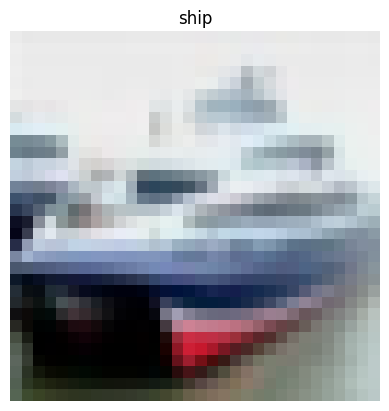

In [40]:
img = (image / 2 + 0.5).numpy()
plt.imshow(np.transpose(img, (1, 2, 0))) # (c, h, w) -> (h, w, c)
plt.title(classes[label])
plt.axis('off')
plt.show()

Prepare Vision Transformer model

In [41]:
model = VisionTransformer(args.n_channels, args.embed_dim, args.n_layers, 
                              args.n_attention_heads, args.forward_mul, args.image_size, 
                              args.patch_size, args.n_classes, args.dropout)
model.load_state_dict(torch.load(args.model_path, weights_only=True, map_location=args.device))
model.eval()
print(model)

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=128, out_features=128, bias=True)
        (keys): Linear(in_features=128, out_features=128, bias=True)
        (values): Linear(in_features=128, out_features=128, bias=True)
        (out_projection): Linear(in_features=128, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=128, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, 

Pass image through ViT model

In [42]:
# logits = model(image.unsqueeze(0))

Create folder for attention map output

In [43]:
# time = datetime.datetime.now()
# timestamp = str(time.strftime('%Y-%m-%d-%H-%M'))
# os.makedirs(f"attention_data/{timestamp}", exist_ok=True)